<a href="https://colab.research.google.com/github/rttsui/tensorflow-rnn-shakespeare/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bikers on the Fremont bridge
Example adapted from the [Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html)

## Set up: Download (and load) data

In [1]:
# Download data(you can download it by uncommenting and runing this line of code)
#!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD
import matplotlib.pyplot as plt                      # for making plots
import numpy as np                                   # for doing numerical operations                  
import pandas as pd                                  
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.model_selection import train_test_split # splitting data
from sklearn.neighbors import KNeighborsRegressor    # regressor
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import make_pipeline           # for making pipelines
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Aggregate data to the daily level
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
# This operation shows us first 10 rows of this dataset
counts.head(10)
# The next few operations sum up the total number of bikers that have crossed
# the Fremont Bridge on a given day and makes a new dataframe that gives us
# date and total number of bikers that crossed that day.
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns
daily.head(10)

,Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0
2012-10-08,3537.0
2012-10-09,3501.0
2012-10-10,3235.0
2012-10-11,3047.0


# Data Prep: Adding Features

In [3]:
# Load weather data (downloaded from: https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND)
weather = pd.read_csv('weather.csv', index_col='DATE', parse_dates=True)
# Create dry_day column
# This basically creates a new feature called dry day by checking if the 
# value of the precipitation('PRCP') column is 0 for that row. If it is,
# it means it is a dry day and is assigned a numerical value of 1.Else, it
# it is assigned a numerical value of zero.
weather['dry_day'] = (weather['PRCP'] == 0).astype(int)
weather.head(10)

,STATION,NAME,PRCP,TAVG,TMAX,TMIN,WT01,WT02,WT03,WT04,WT05,WT08,WT13,WT14,WT16,WT17,WT18,WT22,dry_day
DATE,,,,,,,,,,,,,,,,,,,
2012-01-01,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.00,NaN,55.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1
2012-01-02,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.43,NaN,51.0,37.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,0
2012-01-03,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.03,NaN,53.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0
2012-01-04,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.80,NaN,54.0,42.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,0
2012-01-05,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.05,NaN,48.0,37.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0
2012-01-06,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.10,NaN,40.0,36.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,0
2012-01-07,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.00,NaN,45.0,37.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1
2012-01-08,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.00,NaN,50.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2012-01-09,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.17,NaN,49.0,41.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,0


In [4]:
# Join selected weather columns
# We are joining the four columns relevant to us in the weather dataset to our
# daily dataframe which has total number of bikers for the given day.
# We choose the 3 columns that are pre-existent in the weather dataset, 
# namely, precipitation, minimum and maximum temperature for the day and 
# our own feature which we made, which is the dry day column.
daily = daily.join(weather[['PRCP', 'dry_day', 'TMIN', 'TMAX']])
daily.head(10)

,Total,PRCP,dry_day,TMIN,TMAX
Date,,,,,
2012-10-03,3521.0,0.00,1,46.0,66.0
2012-10-04,3475.0,0.00,1,47.0,66.0
2012-10-05,3148.0,0.00,1,48.0,71.0
2012-10-06,2006.0,0.00,1,46.0,75.0
2012-10-07,2142.0,0.00,1,46.0,75.0
2012-10-08,3537.0,0.00,1,46.0,70.0
2012-10-09,3501.0,0.00,1,48.0,61.0
2012-10-10,3235.0,0.00,1,47.0,54.0
2012-10-11,3047.0,0.00,1,45.0,57.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(8.0, 17.0)

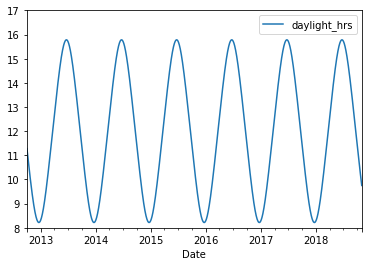

In [5]:
# Compute hours of daylight
# Below is a function that calculates the hours of daylight for a given date
# (Due to the complex nature, we wont get into it this session)
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

# We are basically adding a new feature named daylight_hrs to our daily
# dataframe. It gives the hours of daylight for that particular day
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

# Feature Generation: Categorical Variable(s)

In [6]:
# Get dummy variables from categorical columns (alternative: sklearn OneHotEncoding)
# Make each day of the week a column and the day which it is would get assigned 
# a value of one and the rest a value of 0.
daily['day_of_week'] = daily.index.dayofweek.astype("str")
# Plot: daily[["day", "Total"]].groupby("day").sum().plot()
daily = pd.get_dummies(daily)
daily.head(10)

,Total,PRCP,dry_day,TMIN,TMAX,daylight_hrs,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.00,1,46.0,66.0,11.277359,0,0,1,0,0,0,0
2012-10-04,3475.0,0.00,1,47.0,66.0,11.219142,0,0,0,1,0,0,0
2012-10-05,3148.0,0.00,1,48.0,71.0,11.161038,0,0,0,0,1,0,0
2012-10-06,2006.0,0.00,1,46.0,75.0,11.103056,0,0,0,0,0,1,0
2012-10-07,2142.0,0.00,1,46.0,75.0,11.045208,0,0,0,0,0,0,1
2012-10-08,3537.0,0.00,1,46.0,70.0,10.987503,1,0,0,0,0,0,0
2012-10-09,3501.0,0.00,1,48.0,61.0,10.929950,0,1,0,0,0,0,0
2012-10-10,3235.0,0.00,1,47.0,54.0,10.872560,0,0,1,0,0,0,0
2012-10-11,3047.0,0.00,1,45.0,57.0,10.815345,0,0,0,1,0,0,0


# Abbreviated EDA

We now see how various features are correlated with the number of bikers that crossed the fremont bridge. We want to be able to see how much influence features have on our target variable, so that we can get a better idea of which features we can use in our ML model

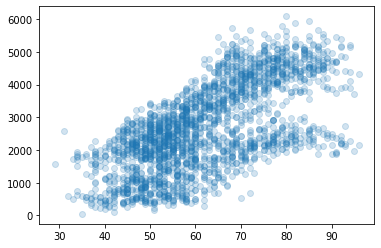

In [8]:
# What is the relationship between bikers and temperature?
plt.scatter(daily.TMAX, daily.Total, alpha=.2)

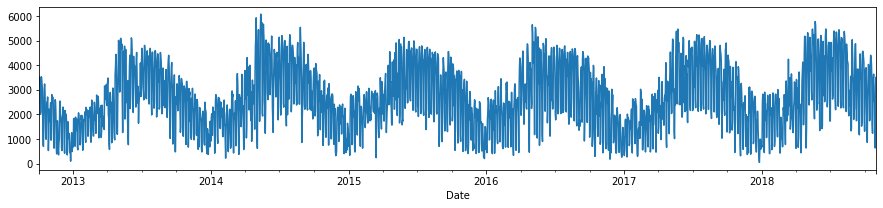

In [9]:
# What is the relationship between bikers and date?
plt.figure(figsize=(15, 3))
daily.Total.plot()

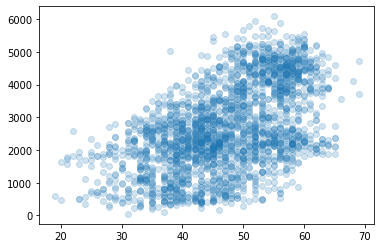

In [10]:
# What is the relationship between bikers and (min) temperature?
plt.scatter(daily.TMIN, daily.Total, alpha=.2)

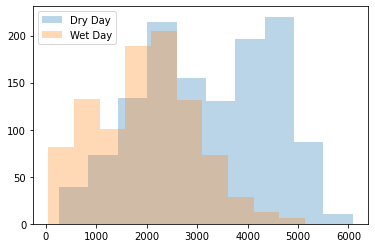

In [11]:
# What is the distribution of bikers on dry/wet days?
plt.figure()
plt.hist(daily.Total[daily.dry_day == True], label="Dry Day", alpha = .3)
plt.hist(daily.Total[daily.dry_day == False], label="Wet Day", alpha = .3)
plt.legend()

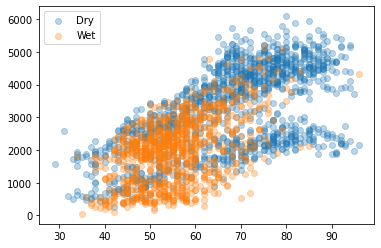

In [13]:
# How does the number of bikers vary by temperature and wet/dry?
# We want to see the correlation between temperature and dry day on the bikers
# We see the number of bikers for various maximum temperatures for dry and wet
# days. While we might not see a necessarily linear correlation, we do see that
# there is a larger positive correlation between max temperature on dry days and 
# number of bikers as compared to that on a wet day. 
plt.figure()
plt.scatter(daily.TMAX[daily.dry_day == True], daily.Total[daily.dry_day == True], alpha = .3, label="Dry")
plt.scatter(daily.TMAX[daily.dry_day == False], daily.Total[daily.dry_day == False], alpha = .3, label="Wet")
plt.legend()

# Modeling: KNN Regressor

##What is KNN Regressor model: 

*   **KNN** stands for K Nearest Neighbors. This one of the standard models data scientists use to model their data.
*   *Basically, it is an algorithm that is used to check the distance of a new point from the nearest data points on the plot, so we can classify the point accordingly*.
 
* **For example**, on the previous plot 
for a given value of temperature if we draw a vertical line, we would see that there are multiple data points around that. We want to see the nearest points(basically number of bikers for that temperature) and be able to predict what our target value might be, given our value on the X-axis.

* We define K: The number of nearest neighbors we want the algorithm to look at while making our prediction. The more we make the value of K, we tend to avoid overfitting the data.

## Why we use KNN?


*   It works great where the correlation between features and the target isn't necessarily linear, hence it would be more appropriate than using an OLS regression model.
*   It is simple to implement and handles non-linearity well.
* Fitting the model also tends to be quick: the computer doesn’t have to calculate any particular parameters or values





In [0]:
# Split data into training and testing data
# We
train_features, test_features, train_outcome, test_outcome = train_test_split(
    daily.drop("Total", axis=1),
    daily.Total,
    test_size=0.30, 
    random_state=11
)

## What is a scaler?

It basically scales our data. What does that mean? 
* Some models tend to produce better and more accurate results when all the input data(features) are relatively on the same scale. As in, the values of the data in our features are somewhat on the same scale.
* For example, if one of our features has values ranging from 10 to 100 and other features have values from 1 million to 10 million, our features **are not** in the same relative scale. 
* Therefore, a scaler will perform appropriate transformations on our data in the features and try and keep them in the same relative scale. ***The distribution of the data still remains the same***

In [16]:
# Create a scaler and your classifier
# We will use a MinMaxScaler() for our transformations where,
# from each value in the columns the min value of the column is subtracted,
# followed by dividing it by the range of the column(max - min).
scaler = MinMaxScaler()
knn_reg = KNeighborsRegressor()

# Define a pipeline that uses your scaler and classifier
pipe = make_pipeline(scaler, knn_reg)

# Define a grid to search through
# We are simply making a dictionary of the parameters here. We need to choose the
# best parameters from these available ones to use for our model.
param_grid = {'kneighborsregressor__n_neighbors':range(1, 5), 'kneighborsregressor__weights':["uniform", "distance"]}

# Perform a  grid search of your pipeline
# Luckily, the grid search of our pipeline will output our best parameteres for 
# us below, which we can use. It does so according to the scoring we want to
# use for our model, the available parameters we have given from above and
# the regressor and scaler we have chosen to use from above.
# If the parameters to search are more this takes longer to run!!
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")
grid.fit(train_features, train_outcome)
grid.score(test_features, test_outcome)
grid.best_params_

{'kneighborsregressor__n_neighbors': 4,
 'kneighborsregressor__weights': 'distance'}

-374.8642675177574

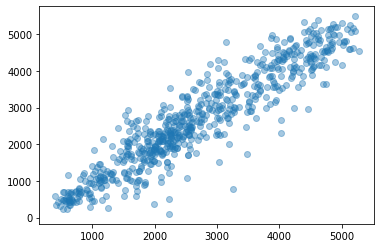

In [17]:
# Compare prediction to (test) data
plt.scatter(grid.predict(test_features), test_outcome, alpha=.4)
grid.score(test_features, test_outcome)

# Feature Generation: Polynomial Transformations

In [0]:
# Add a polynomial transformation to the pipeline
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()

In [19]:
# Define a pipeline that includes the polynomial transformation
pipe = make_pipeline(poly, scaler, knn_reg)

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':range(1, 3), 
              'kneighborsregressor__n_neighbors':range(1, 5), 
              'kneighborsregressor__weights':["uniform", "distance"]}

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")
grid.fit(train_features, train_outcome)
grid.score(test_features, test_outcome)

-374.8642675177574

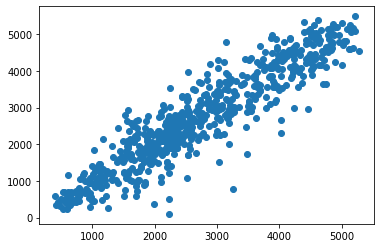

In [20]:
plt.scatter(grid.predict(test_features), test_outcome)

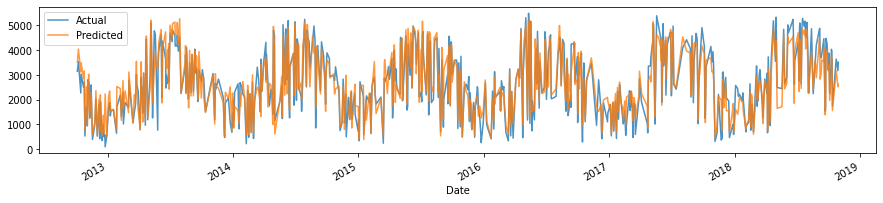

In [21]:
# Visualize time trends
test_data = test_features.join(test_outcome)
test_data['preds'] = grid.predict(test_features)
plt.figure(figsize=(15, 3))
test_data.Total.plot(label="Actual", alpha = .8)
test_data.preds.plot(label="Predicted", alpha = .8)
plt.legend()

# Error assessment: find systematic errors

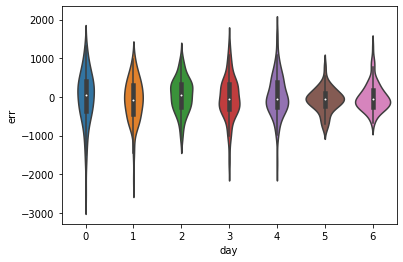

In [22]:
# Why are we getting this wrong?
# Assess error by day of the week
test_data['day'] = test_data.index.dayofweek
test_data['err'] = test_data.Total - test_data.preds
sns.violinplot(y="err", x="day", data=test_data)

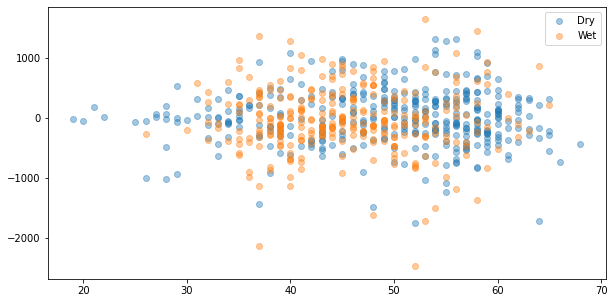

In [23]:
# Assess error by temperature and dry_day
plt.figure(figsize=(10, 5))
plt.scatter(test_data.TMIN[test_data.dry_day == True], test_data.err[test_data.dry_day == True], alpha=.4, label="Dry")
plt.scatter(test_data.TMIN[test_data.dry_day == False], test_data.err[test_data.dry_day == False], alpha=.4, label="Wet")
plt.legend()

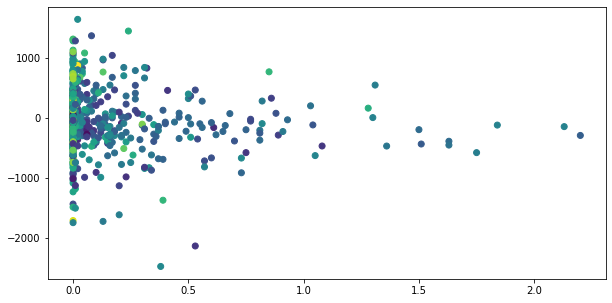

In [24]:
# Assess error by precipitation
plt.figure(figsize=(10, 5))
plt.scatter(test_data.PRCP, test_data.err, c=test_data.TMAX)

# Feature Selection: Select best features
As a form of dimensionality reduction, only select the top percentile features that have a certain threshold of variance.

In [0]:
# Create a percentile selector, add it to the pipeline
# (alternatives a K selectors, PCA, or others)
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
selecter = SelectPercentile()
threshold = VarianceThreshold(.1)
pipe = make_pipeline(poly, threshold, scaler, selecter, knn_reg)

# Define a grid to search through (including the degree of polynomial AND percentile of best features)
param_grid = {
              'polynomialfeatures__degree':range(1, 3),
              'selectpercentile__percentile':range(10, 30, 5),
              'kneighborsregressor__n_neighbors':range(1, 5), 
              'kneighborsregressor__weights':["uniform", "distance"]
}

In [26]:
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")
grid.fit(train_features, train_outcome)
grid.score(test_features, test_outcome)

-849.774024024024